In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import callbacks
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

import pdb

Using TensorFlow backend.


In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Temporal Convolution Network (TCN) Exercise

The goal of this exercise is to implement the TCN block shown below. 

<img src="tcn_block.png">

Below is a function called createTCNBlock() which takes in a few parameters necessary to implement the TCN block.  Your task is to fill out the function and return the output of the final keras layer.

The following code repos were used to assist in the making of the TCN architecture in this demo:

https://github.com/philipperemy/keras-tcn/

https://github.com/Baichenjia/Tensorflow-TCN/

https://github.com/locuslab/TCN/


In [4]:
def createTCNBlock(input_data, dilation_factor=1, num_filters=1, padding='causal', 
                   kernel_size=3, dropout_rate=0.2, activation='relu'):
    '''Create a residual block for use in different temporal convolutional network (TCN) architectures.
    
    Args:
        input_data: a keras model Input block to shape the first Conv1D layer.
        dilation_factor: dilation factor of the convolutions.
        num_filters: the number of convolutional filters.
        padding: padding strategy for the convolutions (see keras Conv1D documentation).
        kernel_size: integer size of the convolution window.
        dropout_rate: percentage of connections to drop (between 0 and 1).
        activation: activation function (default is 'relu')
    Returns:
        the result from the addition of the convolutions and residual connection.
    
    '''
    
    # Make a copy of the input data for use in the residual skip connection
    in_data = input_data
    
    # Create the first temporal layer
    conv_out = keras.layers.Conv1D(filters=num_filters, kernel_size=(kernel_size), 
                                   dilation_rate=dilation_factor, padding=padding)(input_data)
    bn_out = keras.layers.BatchNormalization()(conv_out)
    activation_out = keras.layers.Activation(activation)(bn_out)
    dropout_out = keras.layers.SpatialDropout1D(dropout_rate)(activation_out)
    
    
    # Create the second temporal layer
    conv_out = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, 
                                   dilation_rate=dilation_factor, padding=padding)(dropout_out)
    bn_out = keras.layers.BatchNormalization()(conv_out)
    activation_out = keras.layers.Activation(activation)(bn_out)
    dropout_out = keras.layers.SpatialDropout1D(dropout_rate)(activation_out)

    
    # Create the final layer which is really the residual 1x1 conv plus add step
    # Only do the 1x1 conv if the dimensions dont match
    if(in_data.shape[-1] != dropout_out.shape[-1]):    
        in_data = keras.layers.Conv1D(filters=num_filters, kernel_size=1, padding='same')(in_data)
        
    # Add the input to the output and run that through the activation function
    residual_out = keras.layers.add([in_data, dropout_out])
    activation_out = keras.layers.Activation(activation)(residual_out)
    
    return activation_out


### createTCNModel()

This function simply creates a stack of multiple TCN blocks. The number of blocks is determined by the array length of dilation_factors passed into the function. The output of this function is the result at the current time (after running this through a lambda function to retrieve the current time).

In [5]:
def createTCNModel(input_data, dilation_factors=[1], num_filters=1, padding='casual', 
                   kernel_size=3, dropout_rate=0.2, activation='relu'):
    '''Create a stack of one or multiple TCN blocks.
    
    Args:
        input_data: a keras model Input block to shape the first Conv1D layer.
        dilation_factors: an array dilation factors for the convolutions.
        num_filters: the number of convolutional filters.
        padding: padding strategy for the convolutions (see keras Conv1D documentation).
        kernel_size: integer size of the convolution window.
        dropout_rate: percentage of connections to drop (between 0 and 1).
        activation: activation function (default is 'relu')
    Returns:
        the output of the final TCN block
        
    '''
    
    # Setup a variable to use for capturing TCN block output and feeding 
    # that back into the next block
    output_data = input_data
    
    # For saving the outputs of each TCN block
    saved_output = []
    
    # Create the stack of TCN block based on the number of dilation factors passed in
    for ii in dilation_factors:
        output_data = createTCNBlock(output_data, ii, num_filters, padding,
                                     kernel_size, dropout_rate, activation)
        
        # Save the output of the current block
        saved_output.append(output_data)
        
    # Add all saved outputs
    output_data = keras.layers.add(saved_output)
        
    # This essentially grabs the current time output from the final output layer 
    output_data = keras.layers.Lambda(lambda output: output[:, -1, :])(output_data)    
    
    return output_data


### createExampleSignalData()

This function just creates a simple set of training data to test the TCN. The data being generated is similar to the sequential MNIST dataset where the network is given a long sequence and has to identify which class that sequence belongs to. This illustrates the ability of the network to have memory because it has to remember past input (in the TCN case though the size of the receptive field is just increased to look at all time series data at once).

While similar to the sequential MNIST dataset, this function is sort of simulating data that would be necessary to do GPS signal processing.  Each of the code sequences below (hand crafted, might be some cross-correlation between them but this toy example seems to work) represents a unique satellite. The network is trained to learn what all the "satellites" look like and given a sequence during the prediction step will tell the user which satellite that sequence belongs to. Noise can also be added to the codes. This seems to work (although a noise standard deviation too large will results in mis-classifications) fairly well up to values of 1-2.

In [6]:
def createExampleSignalData():
    # Create a toy signal example
    # The goal here is to train the network to remember what the different
    # sequences look like.

    # Create "pseudorandom" codes for classification (24 samples long)
    code1 = [1,1,1,1,-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1]
    code2 = [-1,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,1,1,1,1,1,1,1,1]
    code3 = [-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1]
    code4 = [1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]
    code5 = [-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,1,1,1,1]

    # Add some noise to the codes if you want...
    noise_stddev = 1

    # Combine code and noise for each signal
    signal1 = code1 + np.random.normal(0, noise_stddev, len(code1))
    signal2 = code2 + np.random.normal(0, noise_stddev, len(code1))
    signal3 = code3 + np.random.normal(0, noise_stddev, len(code1))
    signal4 = code4 + np.random.normal(0, noise_stddev, len(code1))
    signal5 = code5 + np.random.normal(0, noise_stddev, len(code1))

    # Create the x training and y training data
    x_train = np.expand_dims(np.array([signal1, signal2, signal3, signal4, signal5]), axis=2)
    y_train = keras.utils.to_categorical(np.array([[0],[1],[2],[3],[4]]))
    
    return x_train, y_train


### Create the model

This step initializes some of the TCN parameters, generates the training data, and creates the model. A diagram of the created model is also generated and saved to a file called "tcn_model.png".

In [7]:
# Define some of the necessary input variables for createTCNModel()
dilation_factors = [1, 2, 4, 8, 16]
num_filters = 64
kernel_size = 6
dropout_rate = 0.2
activation = 'relu'
padding = 'causal'


# Simulate some data for classification
x_train, y_train = createExampleSignalData()


# Make a dummy input field to use for the TCN model
max_length = len(x_train[0])
num_features = 1


# Input layer should be of size (batch_size, timesteps, input_dim)
input_layer = keras.models.Input(shape=(max_length, num_features)) 


# Build the full temporal convolutional network (TCN) model
output = createTCNModel(input_layer, dilation_factors, num_filters, padding, 
                        kernel_size, dropout_rate, activation, )


# Add a dense layer for classification
model_output = Dense(len(y_train), activation='softmax')(output)


# Initialize and compile the TCN model
model = keras.models.Model(input_layer, model_output)
model.compile(keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Print out the modeif you want
#print(model.summary())


# Save the model to a file for viewing
keras.utils.vis_utils.plot_model(model, to_file='tcn_model.png', show_shapes=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Plot the training data

This step plots the signals which are used to train the model. If the signals are generated with 0 noise the plots should be all 1s and -1s. If the noise is increased to ~1 or so it becomes more difficult for humans to identify which signal the curves belong to.

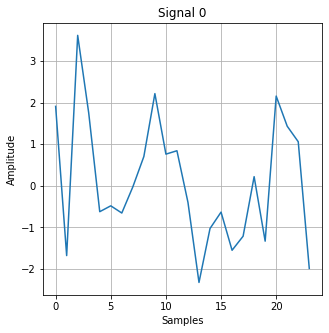

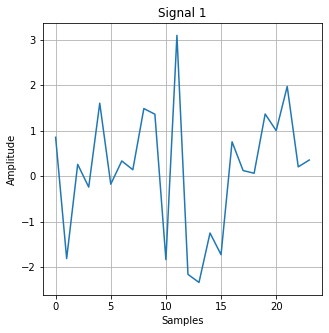

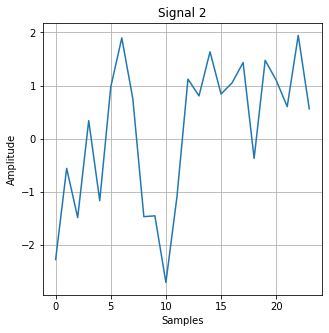

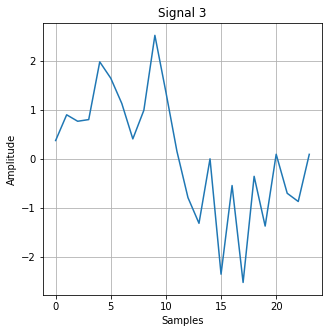

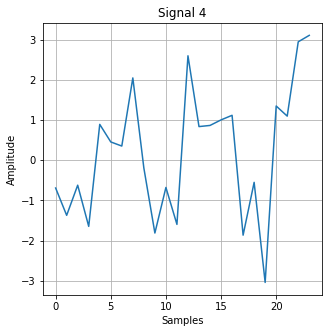

In [8]:
# Plot the signals that will be used for training
for ii in range(len(x_train)):
    plt.figure(figsize=(5,5))
    plt.grid()
    plt.plot(x_train[ii])
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title('Signal ' + str(np.argmax(y_train[ii])))


### Train the model

Train the model on the training data. Nothing special going on here, 50 epochs seems to work well and verbosity is set to maximum.

In [9]:
# Fit the model to the training data
model.fit(x_train, y_train, epochs=50, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 2s - loss: 9.3537 - acc: 0.0000e+00
Epoch 2/50
 - 0s - loss: 3.1264 - acc: 0.4000
Epoch 3/50
 - 0s - loss: 3.2295 - acc: 0.8000
Epoch 4/50
 - 0s - loss: 3.2241 - acc: 0.8000
Epoch 5/50
 - 0s - loss: 5.4813 - acc: 0.6000
Epoch 6/50
 - 0s - loss: 3.2322 - acc: 0.8000
Epoch 7/50
 - 0s - loss: 4.6373e-06 - acc: 1.0000
Epoch 8/50
 - 0s - loss: 3.2236 - acc: 0.8000
Epoch 9/50
 - 0s - loss: 0.6122 - acc: 0.8000
Epoch 10/50
 - 0s - loss: 3.7121 - acc: 0.6000
Epoch 11/50
 - 0s - loss: 0.1970 - acc: 0.8000
Epoch 12/50
 - 0s - loss: 5.3644e-07 - acc: 1.0000
Epoch 13/50
 - 0s - loss: 9.3325e-04 - acc: 1.0000
Epoch 14/50
 - 0s - loss: 5.4836e-07 - acc: 1.0000
Epoch 15/50
 - 0s - loss: 0.1625 - acc: 1.0000
Epoch 16/50
 - 0s - loss: 1.3113e-07 - acc: 1.0000
Epoch 17/50
 - 0s - loss: 0.0048 - acc: 1.0000
Epoch 18/50
 - 0s - loss: 1.5390e-05 - acc: 1.0000
Epoch 19/50
 - 0s - loss: 0.3428 - acc: 0.8000
Epoch 20/50
 - 0s - loss: 9.8539e-05 - a

### Classify a specific code sequence

Again, nothing special going on here. Given a code number (from 0 through 4 unless more codes are added to the generate data function) the model will spit out probabilities for which class the input belongs to. In this toy example the classification accuracy isn't perfect and mis-classifications do happen (especially with noise on the signals) but in general 80-90% accuracy is observed even with noise standard deviation up to 1.

In [15]:
# Pick which code to predict the classification for (0 indexed, [0, 4])
code_num = 3

# Pick which signal you want to classify
signal_to_classify = x_train[code_num]
x_values_to_classify = np.expand_dims(np.array(signal_to_classify.T), axis=2)

# Determine probabilitys that given signal belongs to each class
predicted_y = model.predict(x_values_to_classify, verbose=2)

# Print out the array of probabilities
print(predicted_y)


[[9.4980155e-16 4.4849350e-24 1.1606091e-22 1.0000000e+00 1.6819904e-22]]
